# Country project

In [1]:
from pathlib import Path
import datetime
import io
import ast

import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)

## Get data for daily regions (cases)

The below code will grab the current data and cache it into a local .csv file.  

If you already have the local csv file and it's up-to-date (meaning, the most recent date in it is greater than or equal to yesterday), just use the local csv file to avoid re-downloading uneccesarily.

If you don't already have the local csv file, download it as well.

**useful things**
- check out the variable `iso_mapping`. It maps iso codes to country names.
- You can use this to look at particular country codes. For example, you could type `iso_mapping[['HUN', 'EST']]` to look at the iso conversions for Hungary and Estonia.

In [2]:
# initial parameters
countries_data = Path("countries_data.csv")
yesterday = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=1))
kwargs = dict(parse_dates=["date"])

def get_from_url(url):
    response = requests.get("https://covid.ourworldindata.org/data/owid-covid-data.csv")
    data_raw = response.content.decode('utf-8')
    data_raw_str = io.StringIO(data_raw)
    df_countries = pd.read_csv(data_raw_str, index_col="date", parse_dates=True)
    return df_countries
    
def get_current_data():
    # initial parameters
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    countries_data = Path("countries_data.csv")
    yesterday = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=1))
    kwargs = dict(index_col="date", parse_dates=True)
    
    # read from file
    if not countries_data.is_file():
        df = get_from_url(url)
        df.to_csv(countries_data)
        return df
    else:
        df = pd.read_csv(countries_data, **kwargs)

    # check if dataframe is completely up-to-date.
    # if not, refresh it.
    last_date = pd.Timestamp(df.iloc[-1].name)
    updated = last_date >= yesterday
    if not updated:
        df = get_from_url(url)
        df.to_csv(counties_data)

    
    return df

df_countries = get_current_data()
iso_mapping = df_countries[["iso_code", "location"]].drop_duplicates().set_index("iso_code").squeeze()
iso_mapping.index.name = None
iso_mapping_r = pd.Series(iso_mapping.index.values, index=iso_mapping)

## Matrix 1

The below code creates Matrix 1 for each cell. Feel free to peruse it. You just pass a list of ISO codes into `convert`. More information in the string underneath the `convert` definition (`def`).

**useful things**
- the `iso_to_country` function eats an ISO and outputs a country name. For example, iso_to_country("IRL") returns "Ireland".
- the `country_to_iso` function eats a country and outputs an ISO. For example, country_to_iso("Ireland") returns "IRL".

In [3]:
def iso_to_country(iso):
    """
    Eats an ISO, pops out a country.
    """
    return iso_mapping[iso]

def country_to_iso(country):
    """
    Eats a country, pops out an ISO.
    """
    return iso_mapping_r[country]

def get_population(iso_code):
    """
    Get the population for a particular country, based on total cases and cases per million.
    """
    df = df_countries[df_countries.iso_code == iso_code]
    pops = df["total_cases"] / df["total_cases_per_million"]
    return int(pops.mean() * 1000000)
    
def get_matrix1(ordered_iso_codes, filename=""):
    """
    ``ordered_iso_codes`` looks like, e.g., ['IRL','GBR', 'PRT'].
        You put the iso codes in the order you want and this function outputs a DataFrame
        which has the full country names in the same order.
        
    ``save_csv`` is a filename if you want to save it, otherwise just don't use it.
    """
    region = df_countries.query(f"iso_code in {ordered_iso_codes}")
    region = region.pivot(columns='iso_code', values='total_cases')
    region = region[ordered_iso_codes]
    region.rename(iso_mapping[region.columns].to_dict(), axis=1, inplace=True)
    region = region[region.index > "2020-03-25"]
    region.columns.name = None
    if filename:
        region.to_csv(filename)
    return region

# get ISOs
EU1_isos = ["IRL", "GBR", "PRT", "ESP", "FRA", "ITA", "BEL", "LUX"]
EU2_isos = ['NLD', 'DEU', 'AUT', 'POL', 'CHE', 'SVN', 'CZE', 'SVK']
EU3_isos = ['HUN', 'EST', 'LTU',  'LVA',  'SWE', 'NOR', 'DNK', 'FIN']
EU4_isos = ['ROU', 'BGR', 'SRB', 'BIH', 'HRV', 'GRC',  'CYP', 'MLT']

# get country
EU1 = get_matrix1(EU1_isos, filename="EU1.csv")
EU2 = get_matrix1(EU2_isos, filename="EU2.csv")
EU3 = get_matrix1(EU3_isos, filename="EU3.csv")
EU4 = get_matrix1(EU4_isos, filename="EU4.csv")

## Matrix 2

This code calculates matrix 2. There are small disparity between these numbers and the ones in the Excel spreadsheet -- that's because I calculated population manually based on the original countries_data, rather than using the numbers in the sheet. 

If you'd like you can replace `populations = np.array([get_population(country) for country in iso_list])` with `populations = np.array([4.977, 67.886, 10.296, 47.431, 67.081, 60.317, 11.493, 0.626])` for e.g. EU1. 

I personally think this is too much of a hassle.

In [4]:
def get_matrix2(matrix1, iso_list):
    populations = np.array([get_population(country) for country in iso_list])
    return matrix1.diff().rolling(14).mean() / (populations/1000000)

EU1_m2 = get_matrix2(EU1, EU1_isos)

## Matrix 3

In [5]:
import warnings
def get_matrix3(matrix2):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.log10(matrix2)

EU1_m3 = get_matrix3(EU1_m2)

## Matrix 4

The fun part!

Thoughts:
- Lasso Regression or Elastic Regression is almost always better to use than normal linear regression. I can swap those out very easily if you'd like.

In [6]:
from sklearn.linear_model import LinearRegression

def linear_regression(series, delta):
    pred_idx = series.index + pd.DateOffset(days=delta)
    days_from_start = (series.index - series.index[0]).days
    to_pred = np.array(days_from_start + delta).reshape(-1, 1)
    
    x = days_from_start.values.reshape(-1, 1)
    y = series.values.reshape(-1, 1)
    y_pred = LinearRegression().fit(x, y).predict(to_pred)
    
    return pred_idx, y_pred.squeeze()

def predict_future(df, delta=7):
    last_7_days = df[-7:]
    df_dict = {}
    for col in last_7_days:
        series = last_7_days[col]
        idx, pred = linear_regression(series, delta=delta)
        df_dict[col] = pred

    return 10**pd.DataFrame(df_dict, index=idx)

predict_future(EU1_m3)

,Ireland,United Kingdom,Portugal,Spain,France,Italy,Belgium,Luxembourg
date,,,,,,,,
2021-04-28,84.892414,39.529518,47.184733,182.716588,436.140767,219.272870,292.895824,277.431661
2021-04-29,85.842853,40.702176,46.681978,182.534779,421.821646,216.186870,289.359797,273.281092
2021-04-30,86.803933,41.909621,46.184579,182.353150,407.972642,213.144301,285.866459,269.192618
2021-05-01,87.775773,43.152886,45.692481,182.171703,394.578321,210.144553,282.415295,265.165311
2021-05-02,88.758493,44.433032,45.205626,181.990436,381.623754,207.187023,279.005795,261.198255
2021-05-03,89.752216,45.751154,44.723959,181.809349,369.094504,204.271116,275.637458,257.290549
2021-05-04,90.757065,47.108379,44.247423,181.628443,356.976607,201.396247,272.309785,253.441305


## Plotting

need to set up y-axis, but got the plot

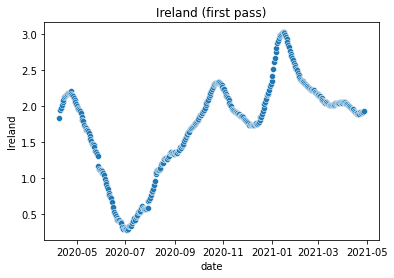

In [10]:
import seaborn as sns

g = sns.scatterplot(data=EU1_m3, x=EU1_m3.index, y="Ireland")
g.set(title="Ireland (first pass)");